# Unsupervised machine learning with k-means clustering 

It is no surprise that news of Califonia's longest drought season (2011-2019) and reccord breaking temperatures have led to some of the worst wildfires the state has seen. 

By analyzing factors that contribute to these fires, high temperatures and precipitation, counties at risk of developing wildfires may be predicted. 

In [2]:
import urllib.request # to open urls and creating requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Obtain the data
Data for the wildfires was scrapped from Wikipedia for the last 10 years (2021 to 2010). The list represents fires that burned more than 1,000 acres (400 ha), or produced significant structural damage or casualties. 

These tables are listed as:
- table_21
- table_20
- table_19
- table_18
etc.

In [3]:
url = "https://en.wikipedia.org/wiki/2020_California_wildfires"
tables = pd.read_html(url)
print("There are : ",len(tables)," tables")

There are :  8  tables


In [ ]:
print(tables[2])

In [107]:
table_20 = tables[2]
table_20.head()

,Name,County,Acres,Start date,Containment date,Notes,Ref
0,Interstate 5,Kings,2060,May 3,May 7,NaN,[29]
1,Range,San Luis Obispo,5000,May 27,May 28,NaN,[30]
2,Scorpion,Santa Barbara,1395,May 31,June 1,NaN,[31]
3,Quail,Solano,1837,June 6,June 10,3 structures destroyed,[32][33]
4,Wood,San Diego,11000,June 8,June 12,Burned on Camp Pendleton,[34]


In [108]:
# add a column to label the year the fire occurred
table_20['year'] = '2020'
table_20.head()

,Name,County,Acres,Start date,Containment date,Notes,Ref,year
0,Interstate 5,Kings,2060,May 3,May 7,NaN,[29],2020
1,Range,San Luis Obispo,5000,May 27,May 28,NaN,[30],2020
2,Scorpion,Santa Barbara,1395,May 31,June 1,NaN,[31],2020
3,Quail,Solano,1837,June 6,June 10,3 structures destroyed,[32][33],2020
4,Wood,San Diego,11000,June 8,June 12,Burned on Camp Pendleton,[34],2020


In [109]:
table_21.head()

,Name,County,Acres,Start date,Containment date,Notes,Ref,year
0,Owens,Kern,1512,May 1,May 7,Unknown cause,[21][22][23],2021
1,Southern,San Diego,5366,May 2,May 6,4 structures destroyed,[24][22],2021
2,Palisades,Los Angeles,1202,May 14,May 26,"Human-caused, suspected arson; 1 firefighter i...",[25],2021
3,Sargents,Monterey,1100,May 30,June 2,Unknown cause,[26],2021
4,Sierra,San Diego,1000,June 9,June 12,NaN,[27][28],2021


Weather data was downloaded from [NOAA](https://www.ncdc.noaa.gov/cag/county/mapping/4/tavg/202003/12/value) for both precipitation and temperature for the state of California. The bulk download contains the average monthly temp/precipitation for the last 127 years. Only the temperatures for the years 2021-2010 were used.

In [93]:
temp = pd.read_csv("C:\\Users\\willd\\Google Drive\\Data Analysis\\Projects\\Fires_clustering\\avg_temps_CA.csv")
temp.head()

,Location ID,Location,Date,temp,Rank,Anomaly (1901-2000 base period),1901-2000 Mean
0,CA-001,Alameda County,202106,69.2,122,4.2,65.0
1,CA-003,Alpine County,202106,61.0,127,7.7,53.3
2,CA-005,Amador County,202106,74.3,127,7.0,67.3
3,CA-007,Butte County,202106,76.5,125,6.4,70.1
4,CA-009,Calaveras County,202106,74.4,126,6.6,67.8


In [94]:
precip = pd.read_csv("C:\\Users\\willd\\Google Drive\\Data Analysis\\Projects\\Fires_clustering\\avg_precip_CA.csv")
precip.head()

,Location ID,Location,Date,inches,Rank,Anomaly (1901-2000 base period),1901-2000 Mean
0,CA-001,Alameda County,202106,0.02,57,-0.12,0.14
1,CA-003,Alpine County,202106,0.68,69,-0.15,0.83
2,CA-005,Amador County,202106,0.22,59,-0.26,0.48
3,CA-007,Butte County,202106,0.07,32,-0.56,0.63
4,CA-009,Calaveras County,202106,0.22,71,-0.19,0.41


# Cleaning the data


Append the year to tables 19-21

In [114]:
table_21['Start date'] = table_21['Start date'] + ', 2021'
table_21.head()

,Name,County,Acres,Start date,Containment date,Notes,Ref,year
0,Owens,Kern,1512,"May 1, 2021",May 7,Unknown cause,[21][22][23],2021
1,Southern,San Diego,5366,"May 2, 2021",May 6,4 structures destroyed,[24][22],2021
2,Palisades,Los Angeles,1202,"May 14, 2021",May 26,"Human-caused, suspected arson; 1 firefighter i...",[25],2021
3,Sargents,Monterey,1100,"May 30, 2021",June 2,Unknown cause,[26],2021
4,Sierra,San Diego,1000,"June 9, 2021",June 12,NaN,[27][28],2021


In [112]:
table_20['Containment date'] = table_20['Containment date'] + ', 2020'
table_20.head()

,Name,County,Acres,Start date,Containment date,Notes,Ref,year
0,Interstate 5,Kings,2060,"May 3, 2020","May 7, 2020",NaN,[29],2020
1,Range,San Luis Obispo,5000,"May 27, 2020","May 28, 2020",NaN,[30],2020
2,Scorpion,Santa Barbara,1395,"May 31, 2020","June 1, 2020",NaN,[31],2020
3,Quail,Solano,1837,"June 6, 2020","June 10, 2020",3 structures destroyed,[32][33],2020
4,Wood,San Diego,11000,"June 8, 2020","June 12, 2020",Burned on Camp Pendleton,[34],2020


In [162]:
# Clean the column names of the tables
# define a function to standardize the column names.
def clean_col(col):
    col = col.strip()
    col = col.replace(" ", "_")
    col = col.lower()
    return col

new_col = []
for i in table_10.columns:
    c_new = clean_col(i)
    new_col.append(c_new)

table_10.columns = new_col

In [151]:
table_21.columns

Index(['name', 'county', 'acres', 'start_date', 'containment_date', 'notes',
       'ref', 'year'],
      dtype='object')

In [158]:
table_12.columns

Index(['name', 'county', 'acres', 'km2', 'start_date', 'containment_date',
       'notes', 'year'],
      dtype='object')

In [156]:
# rename tables 10-13 column contained_date to containment_date
table_10.rename({"contained_date" : "containment_date"}, axis = 1, inplace = True)
table_11.rename({"contained_date" : "containment_date"}, axis = 1, inplace = True)
table_12.rename({"contained_date" : "containment_date"}, axis = 1, inplace = True)
table_13.rename({"contained_date" : "containment_date"}, axis = 1, inplace = True)

Merge the tables into one dataframe:

In [ ]:
# concatinate the wildfire tables into one table
wildfires = pd.concat([table_10, table_11, table_12, table_13, table_14, table_15, table_16, table_17,
                      table_18, table_19, table_20, table_21])

wildfires = pd.DataFrame(wildfires)
wildfires

In [355]:
# remove the km2 column and ref column from the wildfires
wildfires = wildfires.iloc[:, [0,1,2,4,5,7]]
wildfires.head()

,name,county,acres,start_date,containment_date,year
0,Cotton,San Luis Obispo,2044,"May 15, 2010","May 17, 2010",2010
1,McKinley,Riverside,1000,"May 20, 2010","May 22, 2010",2010
2,Robinson,Merced,1600,"June 11, 2010","June 12, 2010",2010
3,Aliso,San Diego,3225,"July 13, 2010","July 13, 2010",2010
4,Sand 2,Kern,1254,"July 16, 2010","July 22, 2010",2010


## Tidy the temp & precip dataframes and merge them together

In [173]:
temp.columns

Index(['Location ID', 'Location', 'Date', 'temp', 'Rank',
       'Anomaly (1901-2000 base period)', '1901-2000 Mean'],
      dtype='object')

In [175]:
# tidy the column names for the temp and precip dataframes
new_col = []
for i in precip.columns:
    c_new = clean_col(i)
    new_col.append(c_new)

precip.columns = new_col
precip.columns

Index(['location_id', 'location', 'date', 'inches', 'rank',
       'anomaly_(1901-2000_base_period)', '1901-2000_mean'],
      dtype='object')

In [179]:
precip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8004 entries, 0 to 8003
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   location_id                      8004 non-null   object 
 1   location                         8004 non-null   object 
 2   date                             8004 non-null   int64  
 3   inches                           8004 non-null   float64
 4   rank                             8004 non-null   int64  
 5   anomaly_(1901-2000_base_period)  8004 non-null   float64
 6   1901-2000_mean                   8004 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 437.8+ KB


In [182]:
# observe the listed counties in the temp dataframe
temp['location'].unique()

array(['Alameda County', 'Alpine County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Modoc County', 'Mono County', 'Monterey County',
       'Napa County', 'Nevada County', 'Orange County', 'Placer County',
       'Plumas County', 'Riverside County', 'Sacramento County',
       'San Benito County', 'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Sierra County', 'Siskiyou County',
       'Solano 

In [188]:
# remove the word County from the temp & precip dataframes to match that of the wildfires dataframe
temp['location'] = temp['location'].str.replace('County', '')
temp.head()

,location_id,location,date,temp,rank,anomaly_(1901-2000_base_period),1901-2000_mean
0,CA-001,Alameda,202106,69.2,122,4.2,65.0
1,CA-003,Alpine,202106,61.0,127,7.7,53.3
2,CA-005,Amador,202106,74.3,127,7.0,67.3
3,CA-007,Butte,202106,76.5,125,6.4,70.1
4,CA-009,Calaveras,202106,74.4,126,6.6,67.8


In [189]:
precip['location'] = precip['location'].str.replace('County', '')
precip.head()

,location_id,location,date,inches,rank,anomaly_(1901-2000_base_period),1901-2000_mean
0,CA-001,Alameda,202106,0.02,57,-0.12,0.14
1,CA-003,Alpine,202106,0.68,69,-0.15,0.83
2,CA-005,Amador,202106,0.22,59,-0.26,0.48
3,CA-007,Butte,202106,0.07,32,-0.56,0.63
4,CA-009,Calaveras,202106,0.22,71,-0.19,0.41


In [190]:
# we only need the location, date and temp or inches columns from the precip and temp dataframes
temp = temp.iloc[:, [1,2,3]]
precip = precip.iloc[:, 1:4]
precip.head()

,location,date,inches
0,Alameda,202106,0.02
1,Alpine,202106,0.68
2,Amador,202106,0.22
3,Butte,202106,0.07
4,Calaveras,202106,0.22


In [ ]:
# merge the temp & precip dataframes by innerjoining them
weather = pd.merge(left=temp, right=precip, on=['location', 'date'], how='left')
weather = pd.DataFrame(weather)
weather

Converting the date column in the weather dataframe to a datetime object will help us extract the year for each row and allow us to analyze according to year.

In [353]:
# convert the date column to a string
weather['date'] = weather['date'].astype(str)

# convert the date column to a datetime format
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m')

# Extract the year from the date column into a new column 'year'
weather['year'] = pd.DatetimeIndex(weather['date']).year

# extract the month into a new column
weather['month'] = pd.DatetimeIndex(weather['date']).month

weather.head()

,location,date,temp,inches,year,month
0,Alameda,2021-06-01,69.2,0.02,2021,6
1,Alpine,2021-06-01,61.0,0.68,2021,6
2,Amador,2021-06-01,74.3,0.22,2021,6
3,Butte,2021-06-01,76.5,0.07,2021,6
4,Calaveras,2021-06-01,74.4,0.22,2021,6


In [ ]:
# generate a separate dataframe for the average temp and inches 
weather_avg = weather.groupby(['location', 'year', 'month']).mean().reset_index()
weather_avg

### Tidying the wildfires dataframe

In [ ]:
# observe how many unique county names there are
wildfires.value_counts('county')

There are rows in the wildfires dataframe with multiple counties. Keep only the first listed county in a separate list and copy this new list to the county column in the wildfires dataframe.

In [ ]:
counties = []

for i in wildfires['county']:
    if ',' in i:
        c = i.split(',')[0]
        counties.append(c)
    else:
        counties.append(i)

counties

In [ ]:
# replace the county column in wildfires with the counties list
wildfires.loc[:,'county'] = counties
wildfires

We can create a separate dataframe where the total acerage burned in a year and in a month can be used in plotting.

In [361]:
# convert the start_date to a datetime format and extract the month
wildfires['start_date'] = pd.to_datetime(wildfires['start_date'], format='%B %d, %Y')
wildfires.head()

,name,county,acres,start_date,containment_date,year
0,Cotton,San Luis Obispo,2044,2010-05-15,"May 17, 2010",2010
1,McKinley,Riverside,1000,2010-05-20,"May 22, 2010",2010
2,Robinson,Merced,1600,2010-06-11,"June 12, 2010",2010
3,Aliso,San Diego,3225,2010-07-13,"July 13, 2010",2010
4,Sand 2,Kern,1254,2010-07-16,"July 22, 2010",2010


In [363]:
# extract the month into a new column 
wildfires['month'] = pd.DatetimeIndex(wildfires['start_date']).month
wildfires.head()

,name,county,acres,start_date,containment_date,year,month
0,Cotton,San Luis Obispo,2044,2010-05-15,"May 17, 2010",2010,5
1,McKinley,Riverside,1000,2010-05-20,"May 22, 2010",2010,5
2,Robinson,Merced,1600,2010-06-11,"June 12, 2010",2010,6
3,Aliso,San Diego,3225,2010-07-13,"July 13, 2010",2010,7
4,Sand 2,Kern,1254,2010-07-16,"July 22, 2010",2010,7


# Exploratory Data Analysis
We can observe how frequent wildfires are in each county and in each year.

In [352]:
fires_total = wildfires.groupby(['county', 'year', 'month']).sum().reset_index()
fires_total.head()

,county,year,month,acres
0,Alameda,2015,8,2700
1,Alpine,2020,8,26759
2,Alpine,2021,6,1320
3,Alpine,2021,7,69832
4,Amador,2015,9,70868


In [ ]:
# sum the total number of acres burned per county
county_acres = wildfires.groupby('county').sum().reset_index()

In [ ]:
# sort the acres column so the bargraph will be sorted in descending order.
county_sorted = county_acres.sort_values('acres')
county_sorted

## We can view the counties containing the total number of acres burned

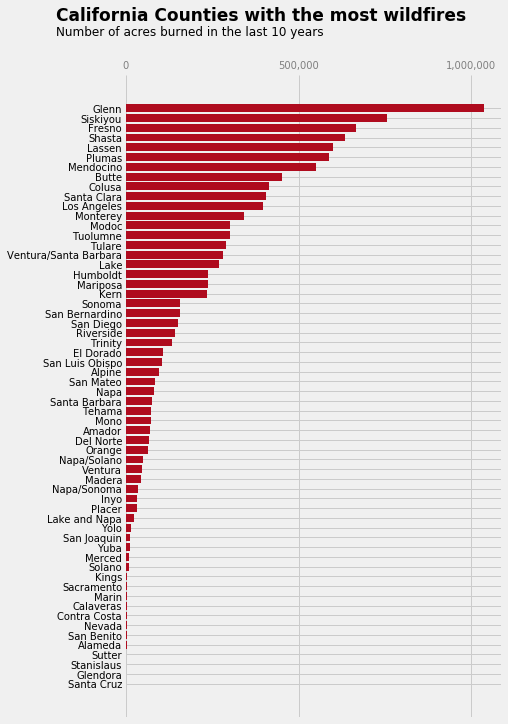

In [279]:
# view this in a barplot
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight') # using the matplotlib style
fig, ax = plt.subplots(figsize=(6, 11))

ax.barh(county_sorted['county'],
        county_sorted['acres'],
        color='#af0b1e')

# Add a title
ax.text(x=-200000, y=68, s='California Counties with the most wildfires',
        size=17, weight='bold')
# Add a subtitle
ax.text(x=-200000, y=66.5, s='Number of acres burned in the last 10 years',
        size=12)

# create a for loop to remove all the spines
for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)

# modify the x-axis tick labels
ax.set_xticks([0, 500000,  1000000])    
ax.set_xticklabels(['0', '500,000', '1,000,000'])
ax.xaxis.tick_top()
ax.tick_params(left=False, top=False, axis='x', colors='grey', direction = 'out', length=1, labelsize=10)

# y-axis label size
ax.tick_params(axis='y', labelsize=10)
plt.show()



## Observe if there is a relationship between temperature and precipitation.

In [328]:
# correlation of temp and the other columns in weather
weather.corr()['temp'].sort_values(ascending=False)

temp      1.000000
year      0.032067
inches   -0.548667
Name: temp, dtype: float64

We see there is a moderate negative correlation (-0.55) between temperature and precipitation.

### Correlation of temp and precipitation is not direct
The relationship can be observed on a scatterplot for each year showing how the relationship changes differs for the last 12 years. It can be observed that when the temperature is above 60°F there is always low precipitation. However, depending on the year, there can be low precipitation even when the temperature is low as in year 2013, 2020 and 2021. 

All three variables (year, temp and precipitation) can be overlayed. This helps visualize an overlay of all the years and looks like 2017 & 2019 had the most wettest seasons compared to the other years.

<Figure size 576x576 with 0 Axes>

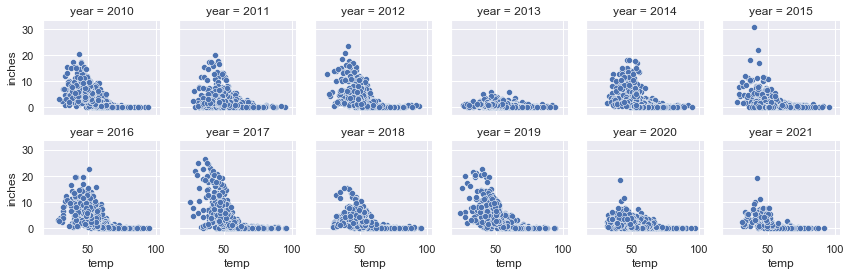

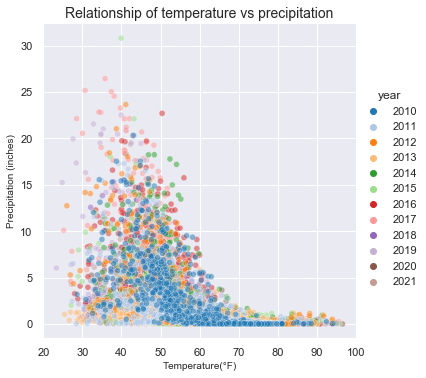

In [346]:
import seaborn as sns
sns.set_theme()
sns.color_palette("tab20", 12)

# Set figure size (width, height) in inches
plt.figure(figsize = ( 8 , 8 ))

g = sns.FacetGrid(weather, col="year", col_wrap=6, height=2)
g.map(sns.scatterplot, 'temp', 'inches')

sns.relplot(data=weather, x='temp', y='inches', hue = 'year', palette ='tab20', alpha=0.5)

# Add a title
plt.title("Relationship of temperature vs precipitation", size = 14)

# Set label for x-axis
plt.xlabel( "Temperature(°F)" , size = 10 )
  
# Set label for y-axis
plt.ylabel( "Precipitation (inches)" , size = 10 )
            
plt.show()

## Observing clusters in the data

In [402]:
# generate the yearly average temp and precipitation for the counties
weather_avg_yr = weather.groupby(['location', 'year']).mean().reset_index()
weather_avg_yr.head()

,location,year,temp,inches,month
0,Alameda,2010,58.283333,1.930833,6.5
1,Alameda,2011,57.925000,1.210833,6.5
2,Alameda,2012,59.258333,1.731667,6.5
3,Alameda,2013,59.466667,0.423333,6.5
4,Alameda,2014,61.950000,1.656667,6.5


In [404]:
# remove whitespaces from the county column
#fires_total['county'] = fires_total['county'].str.strip()
weather_avg_yr['location'] = weather_avg_yr['location'].str.strip()

In [419]:
# Generate a dataframe with the total acres burned per year
fires_total_yr = wildfires.groupby(['county', 'year']).sum().reset_index()
# add column stating wildfire
fires_total_yr['wildfire'] = 'wildfire'
fires_total_yr.head()

,county,year,acres,month,wildfire
0,Alameda,2015,2700,8,wildfire
1,Alpine,2020,26759,8,wildfire
2,Alpine,2021,71152,20,wildfire
3,Amador,2015,70868,9,wildfire
4,Butte,2013,2264,8,wildfire


In [430]:
# check to make sure the county column matches the location column before merging the dataframes.
fires_total_yr['county'][0] == weather_avg_yr['location'][0]

True

In [530]:
# change the year column to an interger
fires_total_yr['year'] = fires_total_yr['year'].astype(int)

In [ ]:
# merge above dataframe with the weather_avg_yr
df4 = pd.merge(left=weather_avg_yr, right=fires_total_yr, how='left', left_on =['location', 'year'], right_on=['county','year'])
df4

In [423]:
# change all Nan in acres to 0
df4['acres'] = df4['acres'].fillna(0)
# change all NaN in wildfire to 'no wildfire'
df4['wildfire'] = df4['wildfire'].replace(np.nan, 'no wildfire')
df4.head(7)

,location,year,temp,inches,month_x,county,acres,month_y,wildfire
0,Alameda,2010,58.283333,1.930833,6.5,NaN,0.0,NaN,no wildfire
1,Alameda,2011,57.925000,1.210833,6.5,NaN,0.0,NaN,no wildfire
2,Alameda,2012,59.258333,1.731667,6.5,NaN,0.0,NaN,no wildfire
3,Alameda,2013,59.466667,0.423333,6.5,NaN,0.0,NaN,no wildfire
4,Alameda,2014,61.950000,1.656667,6.5,NaN,0.0,NaN,no wildfire
5,Alameda,2015,61.050000,0.865833,6.5,Alameda,2700.0,8.0,wildfire
6,Alameda,2016,60.366667,1.879167,6.5,NaN,0.0,NaN,no wildfire


In [424]:
# get rid of unnecessary columns
df4 = df4.iloc[:, [0,1,2,3,6,8]]
df4.head(7)

,location,year,temp,inches,acres,wildfire
0,Alameda,2010,58.283333,1.930833,0.0,no wildfire
1,Alameda,2011,57.925000,1.210833,0.0,no wildfire
2,Alameda,2012,59.258333,1.731667,0.0,no wildfire
3,Alameda,2013,59.466667,0.423333,0.0,no wildfire
4,Alameda,2014,61.950000,1.656667,0.0,no wildfire
5,Alameda,2015,61.050000,0.865833,2700.0,wildfire
6,Alameda,2016,60.366667,1.879167,0.0,no wildfire


## Possible categories to observe clusters
Plotting the data in the above dataframe can help us observe categories that could be used to cluster the data into wildfire or not wildfire potential. The below graph displays scatter plots for different variables in the data frame. The diagonal plots are layered kernel density estimate (KDE), which can be used to show the distribution of the variables. 

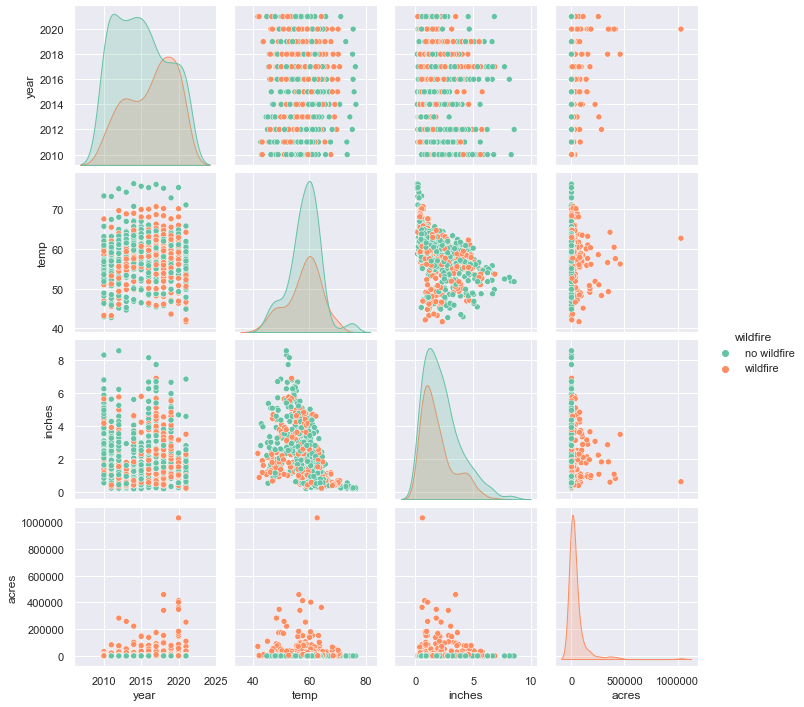

In [426]:
sns.pairplot(df4, hue="wildfire", palette="Set2", diag_kind="kde", height=2.5,)
plt.show()

We do not see that the variables plotted provide a good separation between observed wildfires. This shows that performing a K-means algorithm would not provide any accurate prediction as to whether a wildfire would occur based on temperature and precipitation. 


## K-means with scikit-learn
However, if we did see that the variables were better separated we could proceed with generating a k-means cluster.


In [466]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Obtain the numeric columns of interest you want to train your k-means algorithm on. This would be the temperature, precipitation and the acres burned columns.

In [523]:
# obtain the temp, precip and acres columns (numeric columns) from df4
df = np.array(df4.iloc[:,2:5])
df

array([[5.82833333e+01, 1.93083333e+00, 0.00000000e+00],
       [5.79250000e+01, 1.21083333e+00, 0.00000000e+00],
       [5.92583333e+01, 1.73166667e+00, 0.00000000e+00],
       ...,
       [6.08833333e+01, 4.34583333e+00, 0.00000000e+00],
       [6.29500000e+01, 1.50166667e+00, 1.31100000e+03],
       [5.93166667e+01, 1.83666667e+00, 0.00000000e+00]])

From the dataframe df4 wildfire columns each row representing a data point is labeled with whether there was a wildfire in the county for the year. This column is used to label each data point to compare with the predicted clustering later on.

In [ ]:
# store the wildfire label names in an array
label_names = np.array(df4['wildfire'])
label_names

In [ ]:
# to use the lable_names in the evaluation we need to convert them to integers using the LabelEncoder function
label_encoder = LabelEncoder()
label_named = label_encoder.fit_transform(label_names)

In [520]:
# we can view the classes that correspond to the label_named
label_encoder.classes_

array(['no wildfire', 'wildfire'], dtype=object)

In [521]:
# store the length of the label_encoder.classes_
n_clusters = len(label_encoder.classes_)

Beacause we have multi-dimensional data (3 variables), we must perform principal component analysis and plot the data points according to the first two principal compontnet coordinates. This helps to visualize all our variables on a 2D plot. 

However, before dimensionally reduction we must first scale the values of the different features. This is because temp and precipitaion as well as acres are all measured on different scales (degrees, inches and acres). So it is important to **scale the features to the same range**. This is performed with the `MinMaxScaler()` function, which will take 0-1 as the uniform value range across all features.

In [471]:
# create a preprocessing pipeline that will first implement the StandardScaler and then the PCA analysis
preprocessor = Pipeline(
     [
         ("scaler", MinMaxScaler()),
         ("pca", PCA(n_components=2, random_state=42)),
         ]
     )

In [478]:
# build the kmeans clusting pipeline
clustering = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
                ),
            ),
        ]
    )

In [479]:
# combine both pipelines to generate a chained larger pipeline
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clustering", clustering)
    ])

In [525]:
# perform the pipeline with .fit() on the data.
pipe.fit(df)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clustering',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=2, n_init=50,
                                         random_state=42))]))])

In [526]:
# calculate teh silhouette coefficient {ranges from 0 to 1} where 0 indicates significantly overlapping cluters
# and 1 indicates clusters are well-separated.
preprocessed_data = pipe["preprocessor"].transform(df)
predicted_labels = pipe["clustering"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.4514519911684914

In [527]:
# ARI score of 0 indicates that cluster labels are randomly assigned, and an 
# ARI score of 1 means that the true labels and predicted labels form identical clusters.
adjusted_rand_score(label_named, predicted_labels)

-0.0030078524332383997

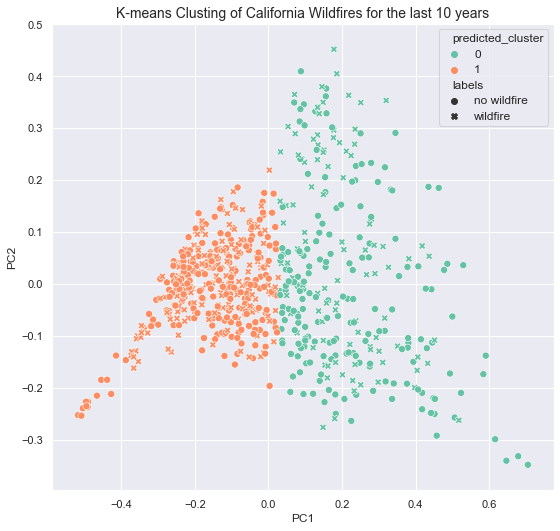

In [529]:
# Save the PCA data into a dataframe
pca_df = pd.DataFrame(
    pipe['preprocessor'].transform(df),
    columns = ["PC1", "PC2"])
pca_df['predicted_cluster'] = pipe['clustering']['kmeans'].labels_
pca_df['labels'] = label_encoder.inverse_transform(label_named)

# plot the dataframe
plt.figure(figsize=(8, 8))
sns.scatterplot("PC1", "PC2", s=50, data = pca_df, hue="predicted_cluster", style="labels", palette = "Set2")
# Add a title
plt.title("K-means Clusting of California Wildfires for the last 10 years", size = 14)

plt.show()

## Making predictions
If we had observed better separation between observed wildfires and no wildfires we could use the model that was trained on previous year's temp and precipitation to predict if a wildfire were to occurr. 

Below is the approach to how this would work.

In [ ]:
# take the new observation of temperature and precipitation
new_observation = [[58.6, 2.2]]
# use the model to predict which cluster the new observation would fall into. The result would be somthing like
# array([0]) indicating the the cluster or centroid 0.
predicted = pipe['clustering']['kmeans'].predict(new_observation)
predicted

# Conclusion

The k-means clustering above shows that it was unable to differentiate between the occurrance of wildfires in California using temperature and precipitation alone. 

This shows that:
1. Additional wildfire data spanning a longer timeframe may be helpful. Also taking all wildfires that occurred, not just ones that bured more than 1,000 acres, could better model the prediction.
2. Additional or alternate variables such as humidity, and how the fire started (lightning, power lines or people) may help in observing more distinct clusters. 

It has been published that 84% of all wildfires are human generated [1](https://www.pnas.org/content/114/11/2946). Additionally, humidity has been shown to be a better indicator in modeling predictions for wildfires than precipitation [2](https://www.pnas.org/content/115/36/E8349#sec-6), [3](https://www.biorxiv.org/content/10.1101/384115v2.abstract).